Procesando frame 144/144, motion 18.72 rad

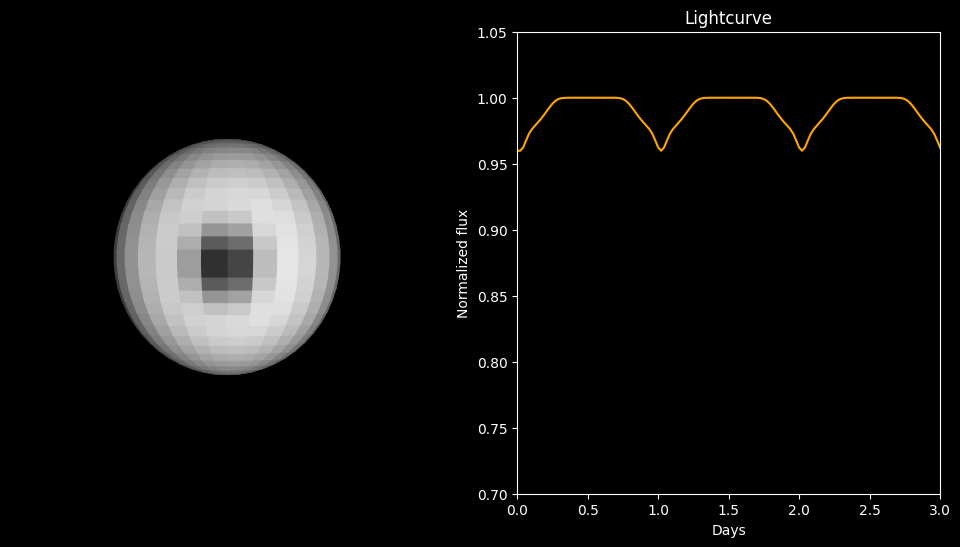

In [13]:
%matplotlib inline

import numpy as np
import pandas as pd
import astropy.units as u
from astropy.constants import R_sun
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from sklearn.preprocessing import normalize
import astropy.units as u


# Stellar parameters 
r = 1* u.R_sun
res = 30
constant = 0.8  # limb darkening coefficient
rotation_period = 1* u.day 

#creating angles
theta = np.linspace(0, 2*np.pi, res)
phi = np.linspace(0, np.pi, res)

#meshgrid for creation of the sphere surface
theta_mesh, phi_mesh = np.meshgrid(theta, phi)

x = r * np.sin(phi_mesh) * np.cos(theta_mesh)
y = r * np.sin(phi_mesh) * np.sin(theta_mesh)
z = r * np.cos(phi_mesh)

# gray texture 
gray_texture = np.ones((res, res))  # intensidad 1 = blanco


# List of spots
spots = []



# parameters position of the spot
spot_theta_deg = 0 #------>Longitude
spot_phi_deg = 90 #------>Latitude
spot_radius_deg = 25

#parameters of how many days periods
observing_baseline_days = 3* u.day#----> Observation time
cadence_time = 30* u.minute#----> Cadence

# frames
total_frames = (observing_baseline_days / cadence_time).decompose().value
total_frames = int(total_frames) 

#Parameter of differential rotation
relative_shear_coeff = 0.2

# convertion function 
def convertion_radians(degree):
    return np.deg2rad(degree)

spot_phi_rad = convertion_radians(spot_phi_deg)
spot_radius_rad = convertion_radians(spot_radius_deg)
spot_theta_rad = convertion_radians(spot_theta_deg)

# Point of view of the sphere

elev = 0
azim = 0

elev_rad = convertion_radians(elev)
azim_rad = convertion_radians(azim)

v_x = np.cos(elev_rad) * np.cos(azim_rad)
v_y = np.cos(elev_rad) * np.sin(azim_rad)
v_z = np.sin(elev_rad)

# Limb darkening
mu = (x * v_x + y * v_y + z * v_z) / r
mu = np.clip(mu, 0, 1)


# limb darkening function 
def limbdarkening(u):
    return (1 - u * (1 - mu))
lineal_darkening = limbdarkening(constant)
gray_texture *= lineal_darkening


def spot_theta(rotation_period, spot_colatitude, relative_shear):
    """
    Parameters:
    - rotation_period: rotation period of the sta
    - initial_latitude: latitud of spot(radians)
    - total_frames:.
    Returns:
    - theta in radians.
    """
    latitude = np.pi / 2 - spot_colatitude #------->the spehre latitude is from 0  to 2pi, so in equator the colatitude will be pi?2
    angular_vel_equa= 2*np.pi*u.rad/rotation_period
    angular_velocity = angular_vel_equa*(1-relative_shear*np.sin(latitude)**2)
    return angular_velocity
    
angular_velocity = spot_theta(rotation_period, spot_phi_rad, relative_shear_coeff)


def flux_plot(flux):
    ''' Function take a list normalizing the flux, converting the list in a csv file and rename the columns
    and return a plot    
    '''
    flux_norm = normalize([flux], norm="max")[0]
    df = pd.DataFrame(flux_norm)
    df.to_csv("lc_high.csv")
    lc = pd.read_csv("lc_high.csv")
    lc = lc.rename(columns={'Unnamed: 0': 'Days', '0': 'flux_normalized'})#-----> change the name of the columns
    lc.to_csv('lc_high_name.csv')
    return lc.plot(x="Days", y="flux_normalized", alpha=0.5)#----->simple plot of lc


def spot_mask(theta_mesh, spot_theta_rad,phi_mesh,spot_phi_rad):
    '''function for creating spot mask, that could change the size and shape of the spot
    using a gaussian function
    '''
    delta_theta = np.arccos(np.cos(theta_mesh - spot_theta_rad.value))
    delta_phi = np.abs(phi_mesh - spot_phi_rad)
    distance_squared = delta_theta**2 + delta_phi**2
    sigma_squared = (spot_radius_rad / 2)**2
    return np.exp(-distance_squared / (2* sigma_squared))
    


# Figura
plt.style.use('dark_background')# -----> dark background
fig = plt.figure(figsize=(12, 6))

ax_sphere = fig.add_subplot(121, projection='3d')
ax_curve = fig.add_subplot(122)
ax_sphere.set_box_aspect((0.98, 1, 0.95))#-------> symtries of the sun 
ax_sphere.set_axis_off()

ax_curve.set_title('Lightcurve', color='white')
ax_curve.set_xlabel('Days')
ax_curve.set_ylabel('Normalized flux')
ax_curve.set_xlim(0, total_frames*(cadence_time.to(u.day)).value)
ax_curve.set_ylim(0.7, 1.05)
ax_curve.set_facecolor('black')
line_curve, = ax_curve.plot([], [], color='orange')

# Flux saves
fluxes = []

#how many round
rot =[]

def animate(i):
    ax_sphere.clear()
    ax_sphere.set_axis_off()
    ax_sphere.view_init(elev=elev, azim=azim)
    texture = np.copy(gray_texture)



    spot_theta_motion = (spot_theta_rad + angular_velocity*i*cadence_time.to(u.day))

    spot_mask_motion = spot_mask(theta_mesh, spot_theta_motion, phi_mesh, spot_phi_rad)

    
    # Aplicar mancha oscura
    texture *= (1 - 0.9 * spot_mask_motion)


    # Dibujar la superficie
    #surf = ax_sphere.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=texture, shade=False)
    surf = ax_sphere.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=plt.cm.gray(texture), shade=False)

    # visible = mu > 0
    # total_flux = np.sum(texture[visible])
    total_flux = np.sum(texture)

    fluxes.append(total_flux)
    rot.append(spot_theta_motion)
    #Normalizar e ingresar a la curva
    fluxes_normalized = normalize([fluxes], norm="max")[0]
    line_curve.set_data(np.arange(len(fluxes))*(cadence_time.to(u.day)).value, fluxes_normalized)
    #line_curve.set_data(np.arange(len(fluxes)), fluxes)

    print(f"Procesando frame {i+1}/{total_frames}, motion {spot_theta_motion:.2f}",  end='\r')  # -------> to see the process



    return[surf, line_curve]

ani = animation.FuncAnimation(fig, animate, frames=total_frames, interval=60, blit=False,repeat =False)
ani.save('ex.gif', writer='ffmpeg', fps=20)
plt.show()
  

In [79]:
angular_vel_equa= 2*np.pi*u.rad/rotation_period.value

latitude = np.pi / 2 - spot_phi_rad
angular_velocity = angular_vel_equa*(1-0.2*np.sin(latitude)**2)

print(f"Equator velocity {angular_vel_equa} Angular Velocity {angular_velocity}")



Equator velocity3.141592653589793 rad Angular Velocity 3.141592653589793 rad


In [4]:
#make comprobations of how many turns the stars get
turns = rot[-1]/(2*np.pi)
turns.value

2.979166666666667

Frame 144/144

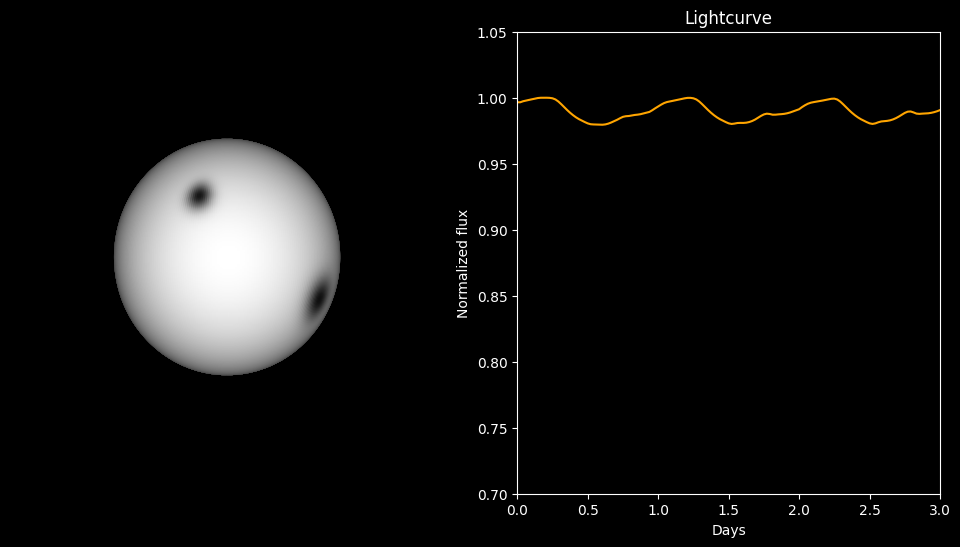

In [4]:
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
import astropy.units as u
from astropy.constants import R_sun
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from sklearn.preprocessing import normalize

# --- Parámetros estelares ---
r = 1 * u.R_sun
res = 60
constant = 0.8  # coeficiente de oscurecimiento del limbo
rotation_period = 1 * u.day

# --- Malla de la esfera ---
theta = np.linspace(0, 2 * np.pi, res)
phi = np.linspace(0, np.pi, res)
theta_mesh, phi_mesh = np.meshgrid(theta, phi)
x = r * np.sin(phi_mesh) * np.cos(theta_mesh)
y = r * np.sin(phi_mesh) * np.sin(theta_mesh)
z = r * np.cos(phi_mesh)

# --- Textura gris inicial ---
gray_texture = np.ones((res, res))

# --- Lista de manchas ---
spots = []

# --- Parámetros de observación ---
observing_baseline_days = 3 * u.day
cadence_time = 30 * u.minute
total_frames = int((observing_baseline_days / cadence_time).decompose().value)

# --- Conversión a radianes ---
def convertion_radians(degree):
    return np.deg2rad(degree)

# --- Punto de vista ---
elev = 0
azim = 0
elev_rad = convertion_radians(elev)
azim_rad = convertion_radians(azim)
v_x = np.cos(elev_rad) * np.cos(azim_rad)
v_y = np.cos(elev_rad) * np.sin(azim_rad)
v_z = np.sin(elev_rad)

# --- Oscurecimiento del limbo ---
mu = (x * v_x + y * v_y + z * v_z) / r
mu = np.clip(mu, 0, 1)
def limbdarkening(u):
    return (1 - u * (1 - mu))
lineal_darkening = limbdarkening(constant)
gray_texture *= lineal_darkening

# --- Velocidad angular diferencial ---
def spot_theta(rotation_period, spot_colatitude, relative_shear):
    latitude = np.pi / 2 - spot_colatitude
    angular_vel_equa = 2 * np.pi * u.rad / rotation_period
    angular_velocity = angular_vel_equa * (1 - relative_shear * np.sin(latitude)**2)
    return angular_velocity

# --- Máscara de mancha ---
def spot_mask(theta_mesh, spot_theta_rad, phi_mesh, spot_phi_rad, spot_radius_rad):
    delta_theta = np.arccos(np.cos(theta_mesh - spot_theta_rad.value))
    delta_phi = np.abs(phi_mesh - spot_phi_rad)
    distance_squared = delta_theta**2 + delta_phi**2
    sigma_squared = (spot_radius_rad / 2)**2
    return np.exp(-distance_squared / (2 * sigma_squared))

# --- Función para agregar manchas ---
def agregar_mancha(latitud_deg, longitud_deg, radio_deg):
    if not (-90 <= latitud_deg <= 90):
        raise ValueError("Latitud debe estar entre -90 y 90 grados")
    if not (0 <= longitud_deg < 360):
        raise ValueError("Longitud debe estar entre 0 y 360 grados")
    if radio_deg <= 0:
        raise ValueError("El radio debe ser positivo")

    colatitud_rad = np.deg2rad(90 - latitud_deg)
    longitud_rad = np.deg2rad(longitud_deg)
    radio_rad = np.deg2rad(radio_deg)
    ang_vel = spot_theta(rotation_period, colatitud_rad, 0.2)  # 0.2 = cte de cizalladura

    spots.append({
        'theta': longitud_rad * u.rad,
        'phi': colatitud_rad,
        'radius': radio_rad,
        'angular_velocity': ang_vel
    })

# Ejemplo de manchas:
agregar_mancha(30, 45, 10)
agregar_mancha(-20, 90, 15)
agregar_mancha(0, 180, 20)

# --- Función para graficar curva de luz ---
def flux_plot(flux):
    flux_norm = normalize([flux], norm="max")[0]
    df = pd.DataFrame(flux_norm)
    df.to_csv("lc_high.csv")
    lc = pd.read_csv("lc_high.csv")
    lc = lc.rename(columns={'Unnamed: 0': 'Days', '0': 'flux_normalized'})
    lc.to_csv('lc_high_name.csv')
    return lc.plot(x="Days", y="flux_normalized", alpha=0.5)

# --- Configuración de figura ---
plt.style.use('dark_background')
fig = plt.figure(figsize=(12, 6))
ax_sphere = fig.add_subplot(121, projection='3d')
ax_curve = fig.add_subplot(122)
ax_sphere.set_box_aspect((0.98, 1, 0.95))
ax_sphere.set_axis_off()
ax_curve.set_title('Lightcurve', color='white')
ax_curve.set_xlabel('Days')
ax_curve.set_ylabel('Normalized flux')
ax_curve.set_xlim(0, total_frames * (cadence_time.to(u.day)).value)
ax_curve.set_ylim(0.7, 1.05)
ax_curve.set_facecolor('black')
line_curve, = ax_curve.plot([], [], color='orange')

# --- Listas para curva de luz ---
fluxes = []

# --- Animación ---
def animate(i):
    ax_sphere.clear()
    ax_sphere.set_axis_off()
    ax_sphere.view_init(elev=elev, azim=azim)
    texture = np.copy(gray_texture)

    for spot in spots:
        theta_mov = spot['theta'] + spot['angular_velocity'] * i * cadence_time.to(u.day)
        mask = spot_mask(theta_mesh, theta_mov, phi_mesh, spot['phi'], spot['radius'])
        texture *= (1 - 0.9 * mask)

    surf = ax_sphere.plot_surface(x, y, z, rstride=1, cstride=1,
                                  facecolors=plt.cm.gray(texture), shade=False)

    total_flux = np.sum(texture)
    fluxes.append(total_flux)
    fluxes_normalized = normalize([fluxes], norm="max")[0]
    line_curve.set_data(np.arange(len(fluxes)) * (cadence_time.to(u.day)).value, fluxes_normalized)
    print(f"Frame {i+1}/{total_frames}", end='\r')
    return [surf, line_curve]

ani = animation.FuncAnimation(fig, animate, frames=total_frames, interval=60, blit=False, repeat=False)
ani.save('ex_imp_h.gif', writer='ffmpeg', fps=20)
plt.show()


### Comparison between differential velocity 

$\Omega(\theta) = \Omega_{\text{eq}} \left(1 - \alpha \sin^2 \theta \right)
$ using the differential rotation formula taken Timo Reinhold we took the constant
$\alpha=0.2$ is a solar like relative shear

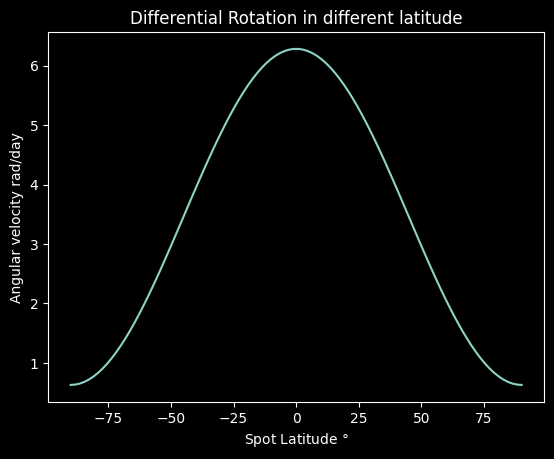

In [5]:
latitude_deg = np.linspace(90, -90, 100)
latitude_rad = np.radians(latitude_deg)

angular_vel_equa = 2*np.pi*u.rad/rotation_period

angular_velocity = angular_vel_equa*(1-0.9*np.sin(latitude_rad)**2)


plt.plot(latitude_deg,angular_velocity.value)
plt.ylabel("Angular velocity rad/day")
plt.xlabel("Spot Latitude $\degree$")
plt.title('Differential Rotation in different latitude')

plt.show()




In [76]:
#parameters of how many days periods
observing_baseline_days = 1 * u.day#----> Observation time
cadence_time = 30 * u.minute#----> Cadence

# frames
total_frames = (observing_baseline_days / cadence_time).decompose().value
total_frames = int(total_frames) 
total_frames

48

<Axes: xlabel='Days'>

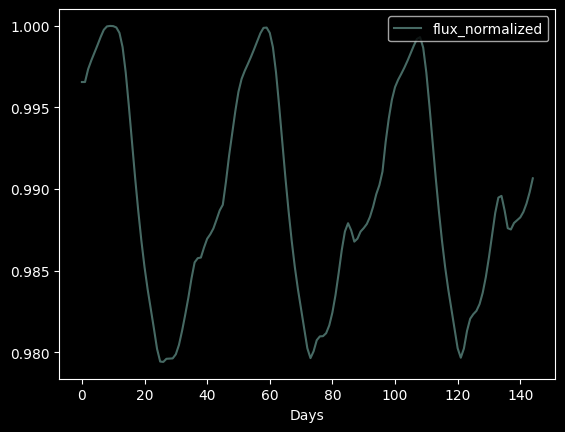

In [3]:
flux_plot(fluxes)

In [2]:
def add_spots(latitude, longitude, radii):
    """
    Add spots.

    Parameters:
    latitude: Latitude in degrees (-90 a 90)
    longitude: Longitude in degrees (0 a 360)
    radii: angular radii 
    """
    # notify about errorxs
    if not (-90 <= latitude <= 90):
        raise ValueError("Latitude between 0 and 180 .")
    if not (0 <= longitude <= 360):
        raise ValueError("Longitud between 0 and 360.")
    if radii <= 0:
        raise ValueError("Radii positive number.")

   
    lat_rad = convertion_radians(latitude)
    lon_rad = convertion_radians(longitude)
    rad_rad = convertion_radians(radii)

    # Guardar la mancha como diccionario
    mancha = {
         "lat": lat_rad,
         "lon": lon_rad,
         "radio": rad_rad
     }
    #mancha =[latitude,longitude,radii]
    spots.append(mancha)

    print(f"Mancha agregada en lat: {latitude}°, lon: {longitude}°, radio: {radii}°")

# Ejemplo de uso
spots = []
add_spots(45, 0, 20)
add_spots(90, 0, 25)
add_spots(-90, 70, 12)

for elem in range(len(spots)):
    
    
    print ('hola')
spots

NameError: name 'convertion_radians' is not defined

In [21]:
import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np
# convertion function 

def convertion_radians(degree):
    return np.deg2rad(degree)
# parameters position of the spot
spot_theta_deg = 0#------>Longitude
spot_phi_deg = 45#------>Latitude
spot_radius_deg = 25



spot_phi_rad = convertion_radians(spot_phi_deg)
spot_radius_rad = convertion_radians(spot_radius_deg)
spot_theta_rad = convertion_radians(spot_theta_deg)


#parameters of how many days periods
observing_baseline_days = 3 * u.day#----> Observation time
days = int(observing_baseline_days.value)
cadence_time = 30 * u.minute#----> Cadence

# frames
total_frames = (observing_baseline_days / cadence_time).decompose().value
total_frames = int(total_frames) 

#Parameter of differential rotation
relative_shear_coeff = 0.2

r = 1* u.R_sun
res = 100
constant = 0.8  # limb darkening coefficient
rotation_period = 2* u.day 

omega_eq=2*np.pi/rotation_period.value


def spot_theta1(rotation_period, initial_latitude, relative_shear, total_frames):
    """
    Parameters:
    - rotation_period: rotation period of the sta
    - initial_latitude: latitud of spot(radians)
    - total_frames:.
    Returns:
    - theta in radians.
    """
    angular_vel_equa= 2*np.pi/rotation_period.value
    
    angular_velocity = angular_vel_equa*(1-relative_shear*np.sin(initial_latitude)**2)
    return angular_velocity, angular_vel_equa
    



angular_velocity, angular_vel_equa = spot_theta1(rotation_period,spot_phi_rad,relative_shear_coeff,total_frames)


print(f"velocidad angular {angular_velocity}  y velocidad en el ecuador {angular_vel_equa}")

velocidad angular 2.827433388230814  y velocidad en el ecuador 3.141592653589793


In [6]:

import astropy.units as u

observing_baseline_days = 10 * u.day#----> Observation time
cadence_time = 30 * u.minute#----> Cadence

# frames
total_frames = (observing_baseline_days / cadence_time).decompose().value
total_frames = int(total_frames) 
print (total_frames)

480


<Axes: xlabel='Days'>

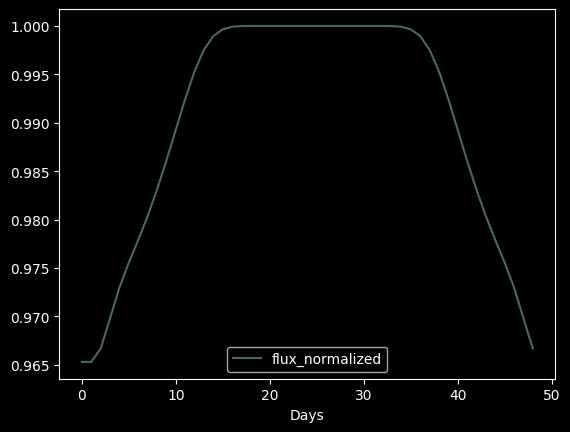

In [17]:
flux_plot(fluxes)

Procesando frame 144/144, motion 18.72 rad

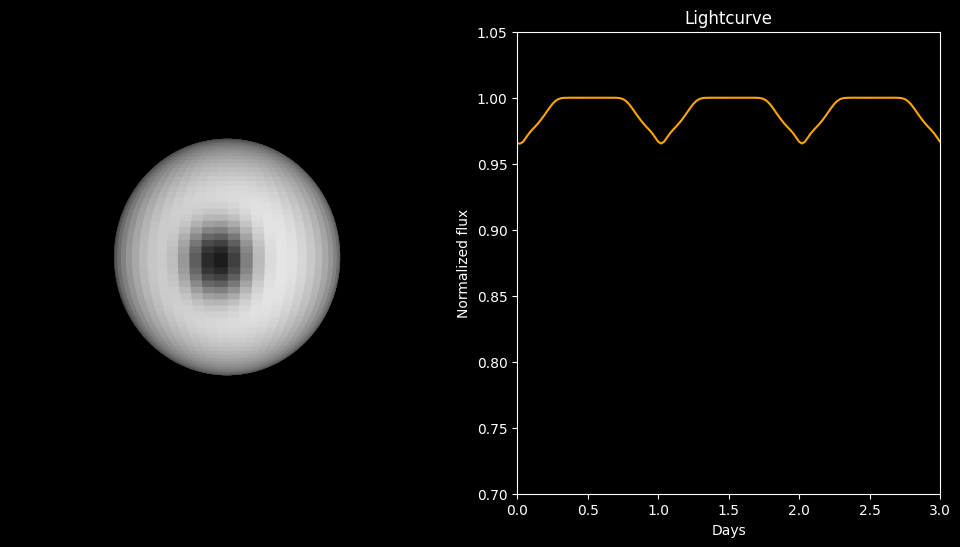

In [2]:
%matplotlib inline
#libraries
import numpy as np
import pandas as pd
import astropy.units as u
from astropy.constants import R_sun
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from sklearn.preprocessing import normalize
import astropy.units as u
#functions 

# convertion function 
def convertion_radians(degree):
    return np.deg2rad(degree)

#function to calculate angular velocity    
def spot_theta(rotation_period, spot_colatitude, relative_shear):
    """
    Parameters:
    - rotation_period: rotation period of the sta
    - initial_latitude: latitud of spot(radians)
    - relative_shear: parameter between pole and equator
    Returns:
    - angular velocity.
    """
    latitude = np.pi / 2 - spot_colatitude #------->the spehre latitude is from 0  to 2pi, so in equator the colatitude will be pi?2
    angular_vel_equa= 2*np.pi*u.rad/rotation_period
    angular_velocity = angular_vel_equa*(1-relative_shear*np.sin(latitude)**2)
    return angular_velocity  

#flux function
def flux_plot(flux):
    ''' Function take a list normalizing the flux, converting the list in a csv file and rename the columns
    and return a plot    
    '''
    flux_norm = normalize([flux], norm="max")[0]
    df = pd.DataFrame(flux_norm)
    df.to_csv("lc_high.csv")
    lc = pd.read_csv("lc_high.csv")
    lc = lc.rename(columns={'Unnamed: 0': 'Days', '0': 'flux_normalized'})#-----> change the name of the columns
    lc.to_csv('lc_high_name.csv')
    return lc.plot(x="Days", y="flux_normalized", alpha=0.5)#----->simple plot of lc


# limb darkening function 
def limbdarkening(u):
    '''calculate a limb darkening lineal and put it to the spehre'''
    return (1 - u * (1 - mu))

#function that create a gaussian mask to represent spots
def spot_mask(theta_mesh, spot_theta_rad,phi_mesh,spot_phi_rad):
    '''function for creating spot mask, that could change the size and shape of the spot
    using a gaussian function
    '''
    delta_theta = np.arccos(np.cos(theta_mesh - spot_theta_rad.value))
    delta_phi = np.abs(phi_mesh - spot_phi_rad)
    distance_squared = delta_theta**2 + delta_phi**2
    sigma_squared = (spot_radius_rad / 2)**2
    return np.exp(-distance_squared / (2* sigma_squared))
    

#animation Function
#@profile
def animate(i, gray_texture, mu, spot_theta_rad, spot_phi_rad, spot_radius_rad,
            theta_mesh, phi_mesh, x, y, z, ax_sphere, elev, azim, ax_curve, line_curve, fluxes, total_frames):
    """ Function where is created the motion and call functions"""
    ax_sphere.clear()
    ax_sphere.set_axis_off()
    ax_sphere.view_init(elev=elev, azim=azim)
    texture = np.copy(gray_texture)

    spot_theta_motion = (spot_theta_rad + angular_velocity*i*cadence_time.to(u.day))

    spot_mask_motion = spot_mask(theta_mesh, spot_theta_motion, phi_mesh, spot_phi_rad)

    
    # Add texture to spot
    texture *= (1 - 0.9 * spot_mask_motion)


    # Plot surface
    #surf = ax_sphere.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=texture, shade=False)
    surf = ax_sphere.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=plt.cm.gray(texture), shade=False)


    total_flux = np.sum(texture)
    fluxes.append(total_flux)
    #rot.append(spot_theta_motion)
    #Normalized curve
    fluxes_normalized = normalize([fluxes], norm="max")[0]
    line_curve.set_data(np.arange(len(fluxes))*(cadence_time.to(u.day)).value, fluxes_normalized)
    #line_curve.set_data(np.arange(len(fluxes)), fluxes)

    print(f"Procesando frame {i+1}/{total_frames}, motion {spot_theta_motion:.2f}",  end='\r')  # -------> to see the process



    return[surf, line_curve]

if __name__ == '__main__':
    
    # Stellar parameters 
    r = 1* u.R_sun
    res = 60#--->resolution
    constant = 0.8  # limb darkening coefficient
    rotation_period = 1* u.day #--->rotation period of the star
    
    # Point of view of the sphere
    elev = 0
    azim = 0
    
    # parameters position of the spot
    spot_theta_deg = 0 #------>Longitude
    spot_phi_deg = 90 #------>Latitude
    spot_radius_deg = 25
    
    #parameters of how many days periods
    observing_baseline_days = 3* u.day#----> Observation time
    cadence_time = 30 * u.minute#----> Cadence
    
    # frames
    total_frames = (observing_baseline_days / cadence_time).decompose().value
    total_frames = int(total_frames) 
    
    #Parameter of differential rotation
    relative_shear_coeff = 0.2
    
    #creating angles
    theta = np.linspace(0, 2*np.pi, res)
    phi = np.linspace(0, np.pi, res)
    
    #meshgrid for creation of the sphere surface
    theta_mesh, phi_mesh = np.meshgrid(theta, phi)
    
    x = r * np.sin(phi_mesh) * np.cos(theta_mesh)
    y = r * np.sin(phi_mesh) * np.sin(theta_mesh)
    z = r * np.cos(phi_mesh)
    
    # gray texture 
    gray_texture = np.ones((res, res))  # intensidad 1 = blanco
    
    
    #convertion paraneters
    spot_phi_rad = convertion_radians(spot_phi_deg)
    spot_radius_rad = convertion_radians(spot_radius_deg)
    spot_theta_rad = convertion_radians(spot_theta_deg)
    elev_rad = convertion_radians(elev)
    azim_rad = convertion_radians(azim)
    
    v_x = np.cos(elev_rad) * np.cos(azim_rad)
    v_y = np.cos(elev_rad) * np.sin(azim_rad)
    v_z = np.sin(elev_rad)
    
    # Limb darkening
    mu = (x * v_x + y * v_y + z * v_z) / r
    mu = np.clip(mu, 0, 1)
    
    lineal_darkening = limbdarkening(constant)
    gray_texture *= lineal_darkening
    
    #motion of spot
    angular_velocity = spot_theta(rotation_period, spot_phi_rad, relative_shear_coeff)#----->only calculate once
    
    
    
    # Figure
    plt.style.use('dark_background')# -----> dark background
    fig = plt.figure(figsize=(12, 6))
    
    ax_sphere = fig.add_subplot(121, projection='3d')
    ax_curve = fig.add_subplot(122)
    ax_sphere.set_box_aspect((0.98, 1, 0.95))#-------> symtries of the sun 
    ax_sphere.set_axis_off()
    
    ax_curve.set_title('Lightcurve', color='white')
    ax_curve.set_xlabel('Days')
    ax_curve.set_ylabel('Normalized flux')
    ax_curve.set_xlim(0, total_frames*(cadence_time.to(u.day)).value)
    ax_curve.set_ylim(0.7, 1.05)
    ax_curve.set_facecolor('black')
    line_curve, = ax_curve.plot([], [], color='orange')
    
    # Flux saves
    fluxes = []
    
    #list to add the value of radians in every frame
    #rot =[]
    
    
    ani = animation.FuncAnimation(
        fig, animate, frames=total_frames, interval=60, blit=False, repeat=False,
        fargs=(gray_texture, mu, spot_theta_rad, spot_phi_rad, spot_radius_rad,
               theta_mesh, phi_mesh, x, y, z, ax_sphere, elev, azim, ax_curve,
               line_curve, fluxes, total_frames)
    )
    ani.save('ex.gif', writer='ffmpeg', fps=20)
    plt.show()



🌀 Período de rotación detectado: 0.772 días


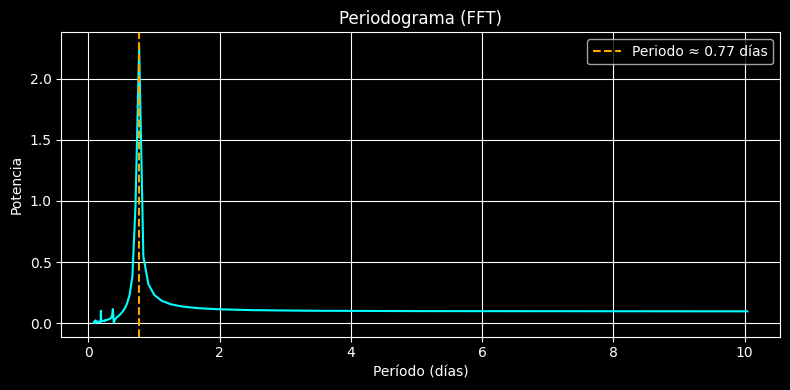

In [39]:
# ========== Análisis de periodo con FFT ==========
from scipy.fft import rfft, rfftfreq
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

# Verificamos si hay datos suficientes
if len(fluxes) > 10:

    # Normalizar flujo
    flux_norm = normalize([fluxes], norm='max')[0]

    # Eje de tiempo en días (tenés 240 frames en 10 días)
    tiempo = np.linspace(0, days, len(fluxes))  # Esto está en días
    N = len(tiempo)
    dt = tiempo[1] - tiempo[0]  # paso temporal en días

    # FFT
    frecuencias = rfftfreq(N, dt)
    espectro = np.abs(rfft(flux_norm - np.mean(flux_norm)))

    # Ignoramos la frecuencia cero (promedio)
    frecuencias = frecuencias[1:]
    espectro = espectro[1:]

    # Buscamos frecuencia dominante
    indice_pico = np.argmax(espectro)
    frecuencia_dominante = frecuencias[indice_pico]
    periodo_dominante = 1 / frecuencia_dominante)

    print(f"\n🌀 Período de rotación detectado: {periodo_dominante:.3f} días")

    # Graficamos el periodograma
    plt.figure(figsize=(8, 4))
    plt.plot(1 / frecuencias, espectro, color='cyan')
    plt.axvline(periodo_dominante, color='orange', linestyle='--',
                label=f"Periodo ≈ {periodo_dominante:.2f} días")
    plt.xlabel("Período (días)")
    plt.ylabel("Potencia")
    plt.title("Periodograma (FFT)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

else:
    print("⚠️ No se encontraron suficientes datos de flujo para estimar el período.")


Procesando frame 240/240

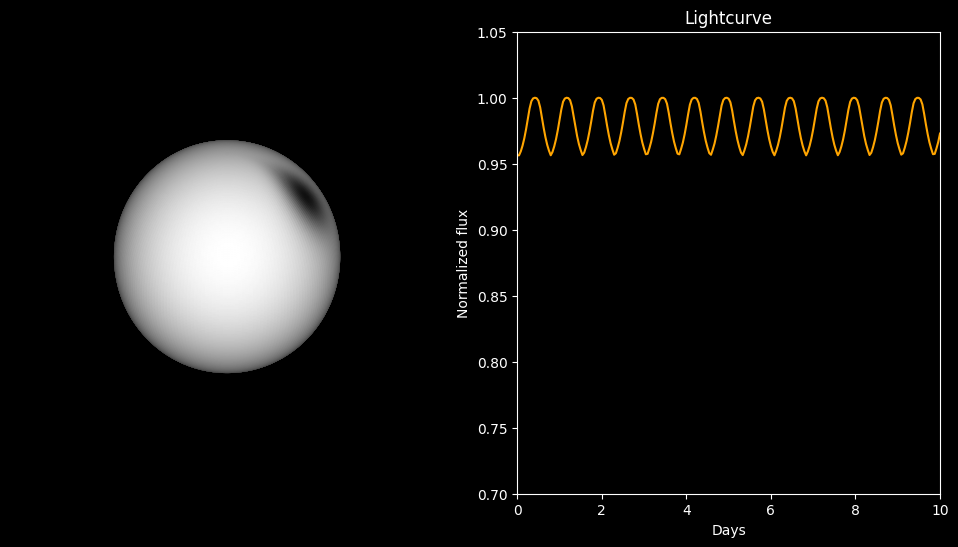

In [6]:
class StarSpotModel:
    def __init__(self, r=1*u.R_sun, res=200, days=10, total_frames=240,
                 spot_theta_deg=0, spot_phi_deg=45, spot_radius_deg=25,
                 omega_eq=2.9*np.pi, delta_omega=0.5*np.pi,
                 elev=30, azim=0, limb_darkening_coeff=0.8):
        
        self.r = r
        self.res = res
        self.days = days
        self.total_frames = total_frames
        self.omega_eq = omega_eq
        self.delta_omega = delta_omega
        self.elev = elev
        self.azim = azim
        self.constant = limb_darkening_coeff
        
        # Manchas
        self.spot_theta_rad = np.deg2rad(spot_theta_deg)
        self.spot_phi_rad = np.deg2rad(spot_phi_deg)
        self.spot_radius_rad = np.deg2rad(spot_radius_deg)
        
        # Malla
        self.theta = np.linspace(0, 2*np.pi, res)
        self.phi = np.linspace(0, np.pi, res)
        self.theta_mesh, self.phi_mesh = np.meshgrid(self.theta, self.phi)
        self.x = self.r * np.sin(self.phi_mesh) * np.cos(self.theta_mesh)
        self.y = self.r * np.sin(self.phi_mesh) * np.sin(self.theta_mesh)
        self.z = self.r * np.cos(self.phi_mesh)

        # Ángulo de visión
        elev_rad = np.deg2rad(elev)
        azim_rad = np.deg2rad(azim)
        self.v_x = np.cos(elev_rad) * np.cos(azim_rad)
        self.v_y = np.cos(elev_rad) * np.sin(azim_rad)
        self.v_z = np.sin(elev_rad)

        # Limb darkening
        self.mu = (self.x * self.v_x + self.y * self.v_y + self.z * self.v_z) / self.r
        self.mu = np.clip(self.mu, 0, 1)
        self.gray_texture = np.ones((res, res)) * (1 - self.constant * (1 - self.mu))
        
        self.fluxes = []

    def compute_spot_theta(self, frame):
        delta_t = self.days / self.total_frames
        time = frame * delta_t
        omega_phi = self.omega_eq - self.delta_omega * np.sin(self.spot_phi_rad)**2
        return self.spot_theta_rad + omega_phi * time

    def compute_spot_mask(self, theta_rad):
        delta_theta = np.arccos(np.cos(self.theta_mesh - theta_rad))
        delta_phi = np.abs(self.phi_mesh - self.spot_phi_rad)
        distance_squared = delta_theta**2 + delta_phi**2
        sigma_squared = (self.spot_radius_rad / 2)**2
        return np.exp(-distance_squared / (2 * sigma_squared))

    def compute_flux(self, texture):
        visible = self.mu > 0
        return np.sum(texture[visible])
        
def animate(i, model, ax_sphere, ax_curve, line_curve):
    ax_sphere.clear()
    ax_sphere.set_axis_off()
    ax_sphere.view_init(elev=model.elev, azim=model.azim)

    texture = np.copy(model.gray_texture)
    theta_spot = model.compute_spot_theta(i)
    mask = model.compute_spot_mask(theta_spot)
    texture *= (1 - 0.9 * mask)

    surf = ax_sphere.plot_surface(model.x, model.y, model.z, rstride=1, cstride=1,
                                   facecolors=plt.cm.gray(texture), shade=False)

    total_flux = model.compute_flux(texture)
    model.fluxes.append(total_flux)

    fluxes_norm = normalize([model.fluxes], norm='max')[0]
    time_days = np.linspace(0, model.days, len(fluxes_norm))
    line_curve.set_data(time_days, fluxes_norm)

    print(f"Procesando frame {i+1}/{model.total_frames}", end='\r')
    return [surf, line_curve]
    
if __name__ == '__main__':
    model = StarSpotModel()

    plt.style.use('dark_background')
    fig = plt.figure(figsize=(12, 6))
    ax_sphere = fig.add_subplot(121, projection='3d')
    ax_curve = fig.add_subplot(122)
    ax_sphere.set_box_aspect((0.98, 1, 0.95))
    ax_curve.set_xlim(0, model.days)
    ax_curve.set_ylim(0.7, 1.05)
    ax_curve.set_facecolor("black")
    ax_curve.set_title("Lightcurve", color="white")
    ax_curve.set_xlabel("Days")
    ax_curve.set_ylabel("Normalized flux")
    line_curve, = ax_curve.plot([], [], color="orange")

    ani = animation.FuncAnimation(fig, animate, frames=model.total_frames, interval=60, blit=False,
                                   repeat=False, fargs=(model, ax_sphere, ax_curve, line_curve))

    ani.save('spot_model_class.gif', writer='ffmpeg', fps=20)
    plt.show()



In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import astropy.units as u
from astropy.constants import R_sun
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from sklearn.preprocessing import normalize

# Stellar parameters 
r = 1* u.R_sun
res = 200
constant = 0.8  # limb darkening coefficient

#creating angles
theta = np.linspace(0, 2*np.pi, res)
phi = np.linspace(0, np.pi, res)

#meshgrid for creation of the sphere surface
theta_mesh, phi_mesh = np.meshgrid(theta, phi)

x = r * np.sin(phi_mesh) * np.cos(theta_mesh)
y = r * np.sin(phi_mesh) * np.sin(theta_mesh)
z = r * np.cos(phi_mesh)

# gray texture 
gray_texture = np.ones((res, res))  # intensidad 1 = blanco

# parameters position of the spot
spot_theta_deg = 0#------>Longitude
spot_phi_deg = 30#------>Latitude
spot_radius_deg = 25

#Parameter of differential rotation
omega_eq = 10 * np.pi   # angular velocity in equator
delta_omega = 0.5 * np.pi  # Difference between equator and pole



# convertion function 
def convertion_radians(degree):
    return np.deg2rad(degree)
    
spot_phi_rad = convertion_radians(spot_phi_deg)
spot_radius_rad = convertion_radians(spot_radius_deg)
spot_theta_rad = convertion_radians(spot_theta_deg)

# Point of view of the sphere
elev = 0
azim = 0

elev_rad = convertion_radians(elev)
azim_rad = convertion_radians(azim)

v_x = np.cos(elev_rad) * np.cos(azim_rad)
v_y = np.cos(elev_rad) * np.sin(azim_rad)
v_z = np.sin(elev_rad)

# Limb darkening
mu = (x * v_x + y * v_y + z * v_z) / r
mu = np.clip(mu, 0, 1)

# limb darkening function 
def limbdarkening(u):
    return (1 - u * (1 - mu))
lineal_darkening = limbdarkening(constant)
gray_texture *= lineal_darkening


def spot_theta(initial_rad, spot_phi_rad, omega_eq, delta_omega, frame, total_frames):
    """
    Initial position of the spots.
    
    Parameters:
    - initial_deg: initial position of spot.
    - spot_phi_rad: latitud of spot(radians)
    - omega_eq: angular velocity.
    - delta_omega: difference between velocity in pole and equator.
    - frame: actual frame.
    - total_frames:.
    Returns:
    - theta in radians.
    """
    # differential rotation
    omega_phi = omega_eq - delta_omega * np.sin(spot_phi_rad)**2
    # Avance angular acumulado
    delta_theta = omega_phi * frame / total_frames
    return initial_rad + delta_theta


def flux_plot(flux):
    ''' Function take a list normalizing the flux, converting the list in a csv file and rename the columns
    and return a plot    
    '''
    flux_norm = normalize([flux], norm="max")[0]
    df = pd.DataFrame(flux_norm)
    df.to_csv("lc_high.csv")
    lc = pd.read_csv("lc_high.csv")
    lc = lc.rename(columns={'Unnamed: 0': 'Days', '0': 'flux_normalized'})#-----> change the name of the columns
    return lc.plot(x="Days", y="flux_normalized", alpha=0.5)#----->simple plot of lc


def spot_mask(theta_mesh, spot_theta_rad,phi_mesh,spot_phi_rad):
    '''function for creating spot mask, that could change the size and shape of the spot
    using a gaussian function
    '''
    delta_theta = np.arccos(np.cos(theta_mesh - spot_theta_rad))
    delta_phi = np.abs(phi_mesh - spot_phi_rad)
    distance_squared = delta_theta**2 + delta_phi**2
    sigma_squared = (spot_radius_rad / 2)**2
    return np.exp(-distance_squared / (2 * sigma_squared))
    

    
# Defining Figure
plt.style.use('dark_background')# -----> dark background
fig = plt.figure(figsize=(12, 6))

ax_sphere = fig.add_subplot(121, projection='3d')
ax_curve = fig.add_subplot(122)
ax_sphere.set_box_aspect((0.98, 1, 0.95))#-------> symtries of the sun 
ax_sphere.set_axis_off()

ax_curve.set_title('Lightcurve', color='white')
ax_curve.set_xlabel('Days')
ax_curve.set_ylabel('Normalized flux')
ax_curve.set_xlim(0, 240)
ax_curve.set_ylim(0.7, 1.05)
ax_curve.set_facecolor('black')
line_curve, = ax_curve.plot([], [], color='orange')

# Flux savings
fluxes = []


def animate(i):
    ax_sphere.clear()
    ax_sphere.set_axis_off()
    ax_sphere.view_init(elev=elev, azim=azim)

    # texture copy
    texture = np.copy(gray_texture)

    # movement of the spot
    spot_theta_motion = spot_theta(spot_theta_rad, spot_phi_rad, omega_eq, delta_omega,i,240)
    spot_mask_motion = spot_mask(theta_mesh, spot_theta_motion, phi_mesh, spot_phi_rad)

    # Aplying mask to the spot 
    texture *= (1 - 0.9 * spot_mask_motion)
    
    # draw surface
    surf = ax_sphere.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=plt.cm.gray(texture), shade=False)
    
    #adding only visible to flux
    visible = mu > 0
    total_flux = np.sum(texture[visible])
    fluxes.append(total_flux)

     #Normalized
    fluxes_normalized = normalize([fluxes], norm="max")[0]
    line_curve.set_data(np.arange(len(fluxes)), fluxes_normalized)
    
    print(f"Procesando frame {i+1}/240", end='\r')  # -------> to see the process
    return[surf, line_curve]
    
#animation and saving gif
ani = animation.FuncAnimation(fig, animate, frames=240, interval=60, blit=False,repeat =False)
ani.save('spot_high.gif', writer='ffmpeg', fps=20)
plt.show()


Procesando frame 240/240